## Comparision based on bivariate Gaussians

This Notebook tries to compare different 3D correlation metrics.
To do so, bivariate Gaussians with varying equicorrelation are generated, and the result of the different correlation metrics is plotted.
Each metric is normalised onto the range [0,1].



In [1]:
x_title = "$\\alpha$"
y_title = "$corr(X,Y,Z)$"

In [2]:
%matplotlib inline

import pycopcor.marginal as pcm
import pycopcor.copula.wolff as pcw
import pycopcor.copula.entropy as pce

import numpy

import matplotlib.pyplot as pp
import collections

import scipy.stats

import pymit


In [8]:
n = 10000

rng = numpy.random.default_rng()

ref = rng.normal(0,1,n)
f_ref = pcm.density(ref)
i_cd_ref_e = pce.empirical_3d(f_ref,f_ref,f_ref)
i_cd_ref_h = pce.histogram_3d(f_ref,f_ref,f_ref)

norm_gauss = lambda x: numpy.sqrt(1 - numpy.exp(-2*x))
norm_max_e = lambda x: x/i_cd_ref_e
norm_max_h = lambda x: x/i_cd_ref_h

def norm_gauss_3d(val):
    d_1 = 3 - 1
    def f(p): return - 1/2 * numpy.log((1-p)**d_1 * (1+d_1*p)) - val
    ret = scipy.optimize.root_scalar(f, bracket=(0, 1))
    if not ret.converged:
        raise RuntimeError("Not Converged")
    return ret.root


print("i_cd_ref_e", i_cd_ref_e)
print("i_cd_ref_h", i_cd_ref_h)


i_cd_ref_e 4.516101919730016
i_cd_ref_h 3.5835189784587778


In [9]:

def process_data(alphas, create_data, copula_funs, other_funs):
    results = collections.defaultdict(list)
    colors = {}

    for alpha in alphas:
        X, title = create_data(alpha, n)
        
        fx_0 = pcm.density(X[:,0])
        fx_1 = pcm.density(X[:,1])
        fx_2 = pcm.density(X[:,2])

        for key in copula_funs:
            c, fun = copula_funs[key]
            res = fun(fx_0, fx_1, fx_2)
            results[key].append(res)
            colors[key] = c
        
        for key in other_funs:
            c, fun = other_funs[key]
            res = fun(X[:,0], X[:,1], X[:,2])
            results[key].append(res)
            colors[key] = c
    return results, colors, title

def plot_data(alphas, results, colors, title, ylim = [-0.1,1.1], xlim = [-0.1,1.1]):
    pp.figure()

    pp.ylim(ylim)
    pp.xlim(xlim)

    for key in results:
        pp.plot(alphas,results[key],color=colors[key][0],marker=colors[key][1],linestyle="dotted" ,label=key)

    pp.plot(alphas,alphas, "--" ,label="Given alpha")
    pp.ylabel(y_title)
    pp.xlabel(x_title)
    pp.title(title)
    pp.legend()
    pp.show()



In [17]:
copula_funs = {
    "$I_{cd,e,NormGauss}$"  : (("tab:blue",     "."), lambda fx_0,fx_1,fx_2: norm_gauss_3d(pce.empirical_3d(fx_0,fx_1,fx_2))), 
    "$I_{cd,h,NormGauss}$"  : (("tab:blue",     "x"), lambda fx_0,fx_1,fx_2: norm_gauss_3d(pce.histogram_3d(fx_0,fx_1,fx_2))) , 
    "$I_{cd,e,NormMax}$"    : (("tab:orange",   "."), lambda fx_0,fx_1,fx_2: norm_max_e(pce.empirical_3d(fx_0,fx_1,fx_2))) , 
    "$I_{cd,h,NormMax}$"    : (("tab:orange",   "x"), lambda fx_0,fx_1,fx_2: norm_max_h(pce.histogram_3d(fx_0,fx_1,fx_2))) , 
    }

other_funs = {
    "$I_{H,10}$"            : (("tab:brown",    "^"), lambda X,Y,Z : pymit.I(X,Y,bins=10)-pymit.I_cond(X,Y,Z,bins=10)),
}


/tmp/ipykernel_577/3492511187.py:16: RuntimeWarning: divide by zero encountered in log
  def f(p): return - 1/2 * numpy.log((1-p)**d_1 * (1+d_1*p)) - val


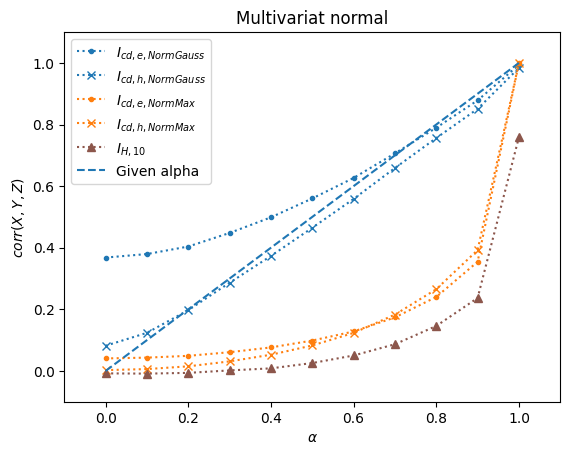

In [18]:
def create_gaussian(corr = 1, n = 10000):
    rng = numpy.random.default_rng()
    mean = (0, 0, 0)

    cov = [[1, corr, corr], [corr, 1, corr], [corr, corr, 1]]
    x = rng.multivariate_normal(mean, cov, (n))
    
    return x, "Multivariat normal"


alphas = numpy.linspace(0,1,11)

modified_data = lambda alpha, n : create_gaussian(alpha, n)
data_for_plot = process_data(alphas, modified_data, copula_funs, other_funs)
plot_data(alphas, *data_for_plot)


## Not normalised

A small experiment to compare the classical mutual infortmation and the mutual information based on copulas.

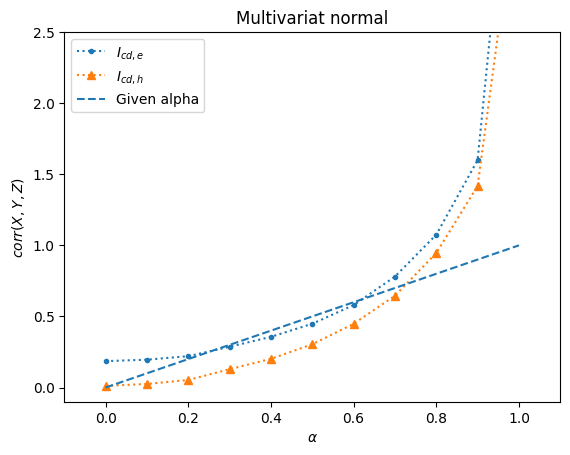

In [16]:

copula_funs = {
    "$I_{cd,e}$"    : (("tab:blue",   "."), lambda fx_0,fx_1,fx_2: pce.empirical_3d(fx_0,fx_1,fx_2)), 
    "$I_{cd,h}$"    : (("tab:orange", "^"), lambda fx_0,fx_1,fx_2: pce.histogram_3d(fx_0,fx_1,fx_2)), 
    }

other_funs = {
    #"$I_{H,10}$"    : (("tab:red", "x"), lambda X,Y : pymit.I(X,Y,bins=10)*numpy.log(10)),
}


alphas = numpy.linspace(0,1,11)

modified_data = lambda alpha, n : create_gaussian(alpha, n)
data_for_plot = process_data(alphas, modified_data, copula_funs, other_funs)

plot_data(alphas, *data_for_plot, ylim=[-0.1,2.5])
    
